# Learning Best Practices for Model Evaluation and Hyperparameter Tuning
In this chapter, the focus is building good model by evaluating performance and fine-tuning the algorithms
The goal is:
  - Assess the performance of machine learning models
  - Dianose the common problems of machine learning algorithms
  - Fine-tune machine learning algorithm
  - Evaluating predictive models using different performance metrics

## Streaming workflows with pipelines
Goal: Learn about `Pipeline` class in scikit-learn

### Loading the Breast Cancer Wisconsin dataset
Breast Cancer Wisconsin dataset, which contains 569 examples of malignant and benign tumor cells. The first two columns in the dataset store the unique ID numbers of the examples and the corresponding diagnoses (M = malignant, B = benign), respectively. Columns 3-32 contain 30 real-valued features that have been computed from digitized images of the cell nuclei, which can be used to build a model to predict whether a tumor is benign or malignant.

In [2]:
# loading data
import pandas as pd
df = pd.read_csv(
 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data',
 header=None
)

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [6]:
#Encoding label data
from sklearn.preprocessing import LabelEncoder
X = df.loc[:,2:].values
y = df.loc[:,1].values
le = LabelEncoder()
y = le.fit_transform(y)

In [8]:
#split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 1)

### Combining transfomers and estimators in pipeline

In [10]:
# Standize, reduce dimension and fit data
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=2),LogisticRegression())
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
test_acr = pipe_lr.score(X_test, y_test)
print(f'Test acuracy: {test_acr:.3f}')

Test acuracy: 0.956


- Pipeline can be thought of series of functions. In example above, data is passed to `fit` of `pipe_lr`, that go through a series of function  
  - First, it's standardized
  - Second, data is dimensional-reduced using `PCA` with `n_components = 2`
  - Third, and finally it go through LogisticRegression (last element of pipeline also called *estimator*)  

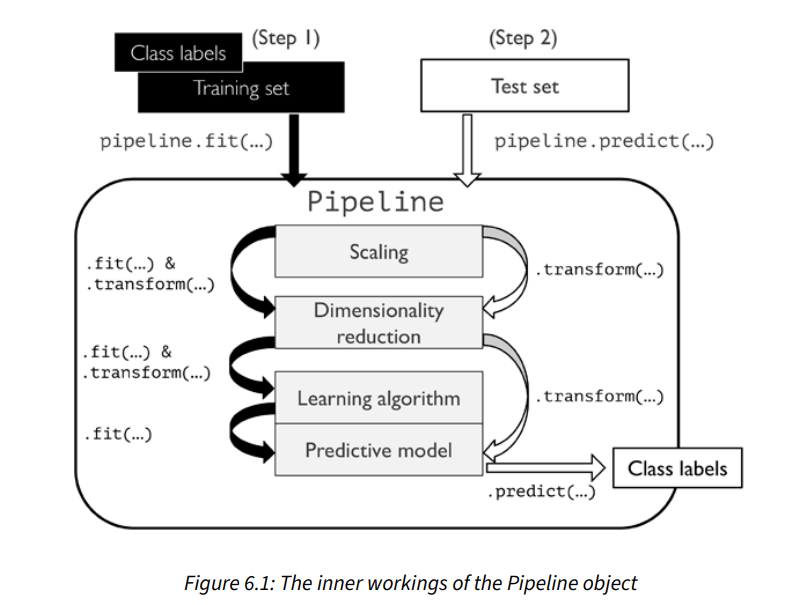
Figure above summarize inner work of pipeline